<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Open Data and Get Basic Statistics

In [3]:
df = pd.read_csv('Data/housing.tgz', compression='gzip')
df = df.rename(index=str, columns={"housing.csv": "longitude"}) # fix a bug
df.index = df.index.map(int)
df = df[:-1]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [5]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


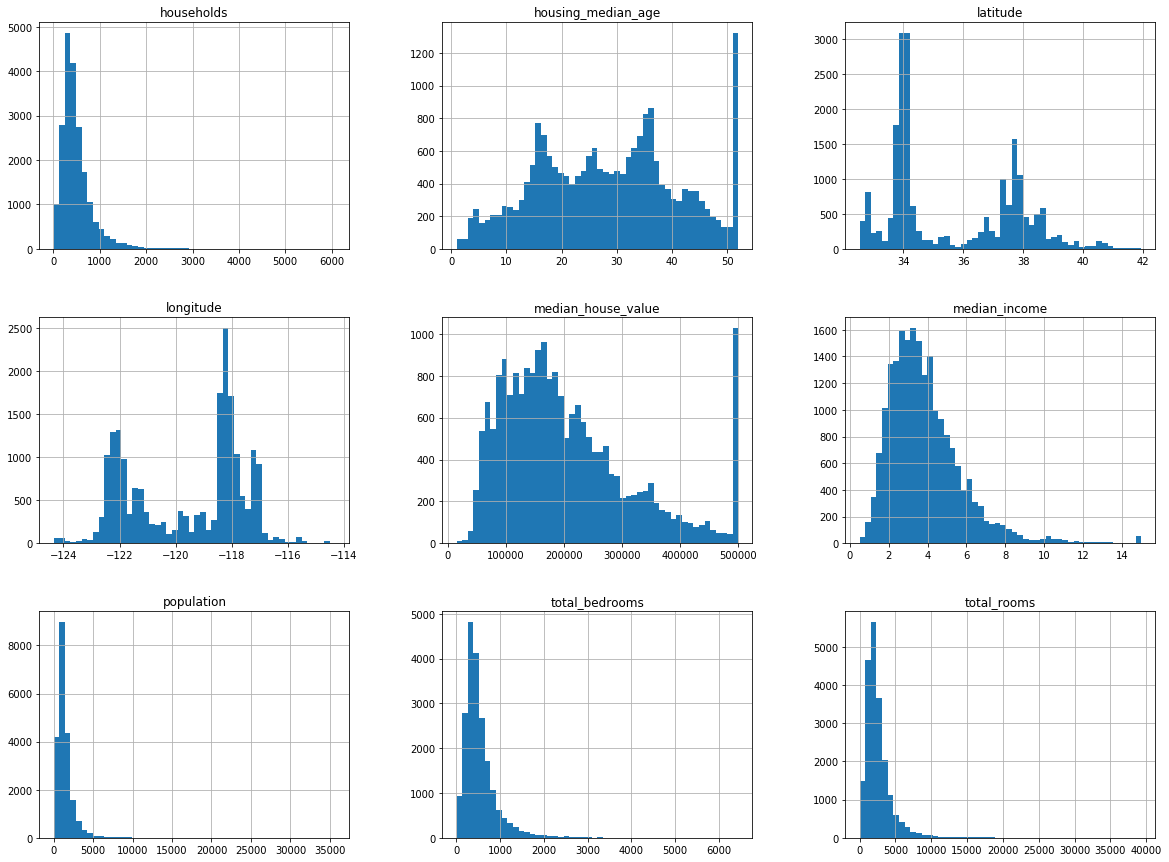

In [6]:
df.hist(bins=50, figsize=(20,15))
plt.show()

# Create a Test Set

Pick 20% of the instances randomly, and set them aside

In [7]:
import numpy as np

In [8]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    
    test_indices = shuffled_indices[: test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = split_train_test(df, 0.2)
print('{} train + {} test'.format(len(train_set), len(test_set)))

16512 train + 4128 test


The problem with the code above is that it gives us a different test set every time we run the machine learning algorithm. Eventually the algorithm will see all of the test set and perform really well on it *merely because it has seen the test set.*

We want to keep the test set seperate. If the data is unchanging, we can use a random number seed to ensure we always pick the same test set. It works on small arrays like such:

In [10]:
np.random.seed(42)
np.random.permutation([1,2,3,4,5])

array([2, 5, 3, 1, 4])

which always returns [2, 5, 3, 1, 4] so long as the original array doesn't change. (Notice the two lines of code are in the same cell).

When the data set does change, however, we need a way of adding the new data to the test and training set while keep the old data in the same sets. This can be accomplished by hashing.

In [11]:
import hashlib

def test_set_check(identifier, test_ratio, h):
    return h(np.int64(identifier)).digest()[-1] < 256 * test_ratio # put in if has value is 20% of 256

def split_train_test_by_id(data, test_ratio, id_column, h=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, h))
    return data.iloc[~in_test_set.values], data.iloc[in_test_set.values]

Below we use the row index as a unique identifier:

In [12]:
df_with_id = df.reset_index() 
train_set, test_set = split_train_test_by_id(df_with_id, 0.2, 'index')

Sometimes, however, rows may get deleted and this hashing method may not work. In this case, we can use the most stable features of each row as unique identifiers. For this housing data set, we can use the longitude and latitude (however this might not always be a unique mapping, which may cause more problems).

In [13]:
df_with_id['id'] = df['longitude'].values * 1000 + df['latitude'].values
train_set, test_set = split_train_test_by_id(df_with_id, 0.2, 'id')

## Using Scikit-Learn

In [14]:
import sklearn
from sklearn.model_selection import train_test_split

The function is useful because if you have two DataFrames with *identical* number of rows, it will split them on the same indices.

In [15]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

So far, we've only dealt with random sampling. This isn't always the best choice of sampling, however. Suppose a company decided to phone 1000 people at random to get an opinion of their product. If they randomly selected a bunch of women and men, then there would be a 12% chance of sampling a skewed sample of either less than 49% female or above 54% female (supposing the population is 50-50). This becomes less and less of an issue, however, as the data set gets bigger.

**Stratified sampling** occurs when the population is broken up into a bunch of subgroups, and the instances are selected at random from these subgroups. 

Consider the example with the housing data. Median income is a very important attribute to predict median housing prices; but if we select a skewed sample of median income data, then the importance of such an attribute may be biased.

## Stratified Sampling on Median Housing Prices

The income medians are distributed between about 1-10, but observing the histogram above, appropriate catagories for income median would be 1, 2, 3, 4, 5: with everything above 5 being put in the top catagory of 5.

In [16]:
df['income_cat'] = np.ceil(df['median_income']/1.5)
df['income_cat'].where(df['income_cat'] < 5, 5.0, inplace=True)

### A little Plot

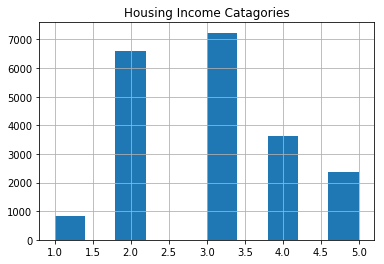

In [17]:
df['income_cat'].hist()
plt.title('Housing Income Catagories')
plt.show()

Now we want to do stratified sampling based on these income catagories.

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

In [19]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
list(split.split(df, df['income_cat']))

[(array([17606, 18632, 14650, ..., 13908, 11159, 15775]),
  array([ 5241, 10970, 20351, ...,  4019, 12107,  2398]))]

In [38]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['income_cat']): #this is only a single loop
    strat_train_set = df.loc[train_index] #train_index is an array
    strat_test_set= df.loc[test_index] # test index is an array

Lets see if this selected proportionally from the catagories as seen in the histogram above. We can print the proportions as follow:

In [39]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

Looks pretty proportional! It's typically good practice to now remove these catagories from the data:

In [40]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [41]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


# Visualizing the Data

We are now only going to look at the training set.

In [42]:
df = strat_train_set.copy()

Here's a neat way to make a scatter plot; we use the longitude and latitude for the location on the plot, the radius of the circle for the size of the population, and the colour for the price of the houses.

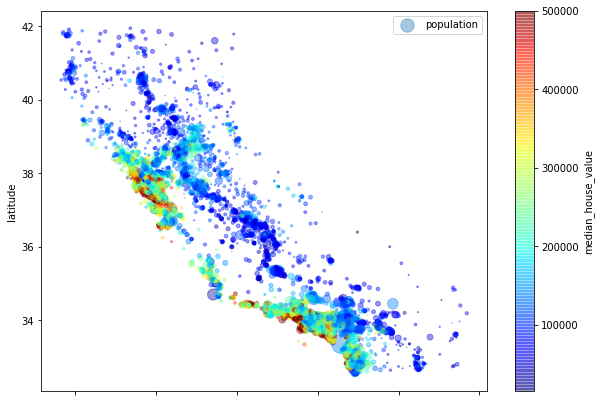

In [43]:
df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
       s=df['population']/100, label='population', figsize=(10,7),
       c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.show()

## Correlations

We can also use pandas scatter_matrix method to find correlations between the various attributes (below we sample 4 of them),

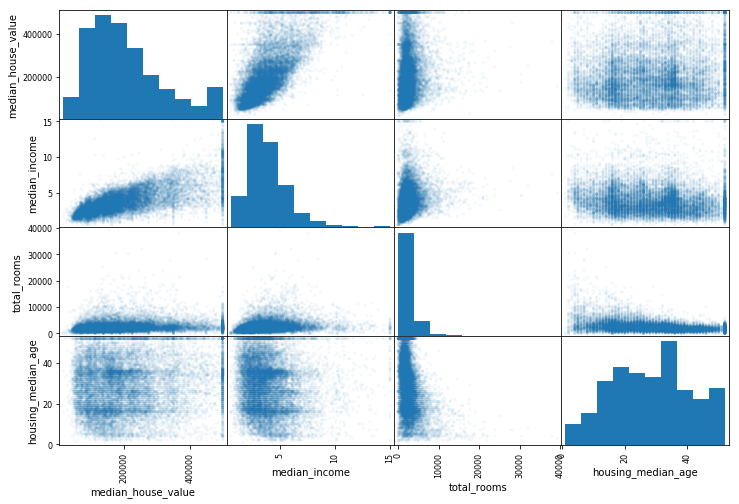

In [44]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
pd.plotting.scatter_matrix(df[attributes], figsize=(12, 8), alpha=0.05)
plt.show()

The horizontal lines at the top of some of these data sets occur because we set a maximum value when collecting data (so all median_house_value's above 500000 are lumped into the same catagory).

We can look at the direct correlation coefficients using the df.corr() method.

In [45]:
corr_matrix = df.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

## Attribute Combinations

Some of the attributes above aren't particularily useful (such as total number of rooms in a district), so we can create ones that might be of more significance.

In [46]:
df['rooms_per_household']=df['total_rooms']/df['households']
df['bedrooms_per_room'] = df['total_bedrooms']/df['total_rooms']
df['population_per_household'] = df['population']/df['households']

In [47]:
corr_matrix = df.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Preparing the Data for Machine Learning

Seperate the parameters from the thing we're trying to predict:

In [48]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

Remove the non-numerical attributes, resulting in a DataFrame of only numbers:

In [49]:
housing_num = housing.drop('ocean_proximity', axis=1)

## Data Cleaning

Since we cannot work with missing features/values (NaN values in the DataFrame) we need to find a way around this. We can use various pandas functions for this:

In [50]:
# This is an example of how you'd do this in pandas - this code doesn't actually modify anything
# since if we actually wanted to modify the dataframe we'd have to add inplace=True. We will use 
# a pipeline later to do this

housing.dropna(subset=['total_bedrooms']) # remove all NaN rows

housing.drop('total_bedrooms', axis=1) # remove this attribute entirely

median = housing['total_bedrooms'].median() #Add median value to the missing entries
housing['total_bedrooms'].fillna(median)

SciKit-Learn has a handy class that takes care of missing values called Imputer. It works as follow:

In [51]:
from sklearn import impute

imputer = impute.SimpleImputer(strategy='median')

This creates an abstract obejct ready to go hard at work on the dataframe. It looks through all the data and replaces the NaN values in each column with the median.

In [52]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

This object above stores the median of all the data columns in its statistics_ instance variable:

In [53]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Below we obtain a numpy array of all the data using imputer:

In [54]:
x = imputer.transform(housing_num)

which can easily be put back into a pandas DataFrame as follows:

In [55]:
housing_tr = pd.DataFrame(x, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


## Handling Data in Text Catagories

### One-Hot-Encoder

In [56]:
housing_cat = housing['ocean_proximity']
housing_cat.head()

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
Name: ocean_proximity, dtype: object

Eariler we left out the ocean proximity data; we can change this data into numerical data using *one-hot-encoding* where we create 1 binary attribute to each component in the data entry. For example, <1H OCEAN might be [1,0,0,0,0] while NEAR OCEAN might be [0,1,0,0,0] (5 total possiblities, each take up one binary bit).

In [57]:
from sklearn.preprocessing import OneHotEncoder

First we use pandas to pandas to map each entry to a different *integer*

In [58]:
housing_cat_encoded, housing_catagories = housing_cat.factorize()
housing_cat_encoded[:10] # print a short sample

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

Now we take each integer and transform it into a 1hot array:

In [59]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))

/Users/lukepolson/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


**Aside**: --------------------

In [60]:
housing_cat_encoded.reshape(-1,1)

array([[0],
       [0],
       [1],
       ...,
       [2],
       [0],
       [3]])

**-----------------------**

We can now take the housing_cat_1hot datatype and transform it into an array:

In [61]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

### The Short Way

We can skip the step where we used pandas to convert the entries to integers and complete all the steps at once:

In [62]:
encoder = OneHotEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1,1)
housing_cat_1hot = encoder.fit_transform(housing_cat_reshaped)

In [63]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

We can get the catagories like such:

In [64]:
encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers

We now implement a class that transforms our data set producing new a column (bedrooms per room). Implementing this as a transformer class will allow us to see if it makes any difference in the machine learning algorithm.

**TransformMixin**: Gives a fit_transform() method that applies the fit method, then applies the transform method. Note for this case, the fit method doesn't do anything since there are no parameters needed for combining columns. Regardless, we still must follow the SciKit Learn rules of having a fit method.

**BaseEstimator**: Gives two extra methods get_params() and set_params() that are useful for automatic hyperparameter tuning.

In [65]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

In [66]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix] #this will be used
        population_per_household = X[:, population_ix] / X[:, household_ix] # this will be used
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, household_ix] # this might be used
        if self.add_bedrooms_per_room:
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

Note whats going on here. There is one boolean *hyperparameter* which determines whether or not the bedrooms_per_room attribute needs to be added. The boolean value is set to True by default. This procedure is can be used to gate any data preparation step that you are not 100% sure about, making it a great way to automatically try out different combinations.

## Feature Scaling

Machine learning algorithms typically don't perform well when numerical attribute have different scales (ex: voltage 1500V vs length 0.01m). There are two ways to get all attributes to have the same scale: *min-max scaling* and *standardization*.

**Min-Max**: Use the transformer *MinMaxScaler*

**Standardization**: Use the transformer *Standard Scaler*

## Pipelines

Used to group all data processing applications into one simple sequence.

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [68]:
num_pipeline = Pipeline([
    ('imputer', impute.SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

## Pandas to NumPy

Since sklearn does not have a way to deal with DataFrames, we must first convert it to a NumPy array. We can do this using a transformer.

In [69]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Calling DataFrameSelector.transform() on a DataFrame will turn it into a NumPy array.

## Putting it all Together

So using everything above, we will

1. DataFrame (numerical data) to Numpy Array
2. Interpolate NaN values using a Imputer
3. Add combined attributes
4. Use a standard scaler to have all numerical attributes in the same range

We also have non-numerical data (ocean proximity). For this we will need another pipeline that

1. Select non-numeric values from DataFrame
2. Use a Catagorical Encoder on the non-numeric data

In [70]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

**Numerical pipeline**

In [71]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', impute.SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

**Non-numerical pipeline**

In [72]:
from sklearn.preprocessing import CategoricalEncoder

In [73]:
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder())
])

We can combine both pipelines together using Scikit's FeatureUnion class which takes in a list of transformers (recall that our past two pipelines are transformers), obtains results from each transformer, and then concatenates them together into a single NumPy array.

In [74]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list =[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

And now we run the full pipeline on the dataset.

In [75]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared # space saving format

<16512x16 sparse matrix of type '<class 'numpy.float64'>'
	with 198144 stored elements in Compressed Sparse Row format>

In [76]:
housing_prepared.toarray()

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# Select and Train a Model

Remember that we wish to predict the median house value of the district.

## Training and Evaluating on the Training Set

### Linear Regression

First we train a linear regression model on the training set.

In [77]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Lets see how well it works on some instances from the training set.

In [78]:
some_data = housing.iloc[:5]
some_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [79]:
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [80]:
print('Predictions:', lin_reg.predict(some_data_prepared))
print('Actual Values:', some_labels.values)

Predictions: [211881.21816491 321219.24214556 210877.63065164  62198.25438662
 194847.84145172]
Actual Values: [286600. 340600. 196900.  46300. 254500.]


It works somewhat, but some of the values are still off by close to 40%. We can measure the RMSE on the whole data set

In [81]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68911.49637588045

The high RMSE can be due to the fact the the features may not provide enough information to produce an accurate prediction, or that the model is not powerful enough. Different features could be obtained by adding, say, the logarithm of the population, but lets first try a more powerful model.

### Decision Tree Regressor

This is a more complex model capable of finding non-linear relationships.

In [82]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Now lets evaluate it on the training set.

In [83]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

While the error might be zero on this training set, the data has likely been overfit and the fit won't perform very well on the set.

## Cross-Validation

A better way to evaluate the decision tree model is to use a function called *train_test_split* to split the training set into a smaller training set and a validation set. Then the model can be trained against the smaller training set and then be validated with the validation set.

In [84]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

Now lets look at these scores.

In [85]:
def display_scores(scores):
    scores = np.sqrt(-scores)
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('STD:', scores.std())
    
display_scores(scores)

Scores: [71111.22486285 70216.13755946 70682.77595021 72959.07421063
 70596.60523472 75054.51954481 74456.42223662 69424.97043901
 77137.27159169 70502.31825281]
Mean: 72214.13198828092
STD: 2424.200236985265


Now the decision tree doesn't look as good as it did earlier. Lets compare it to the linear regression model.

In [86]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
display_scores(scores)

Scores: [67474.1177794  67233.2246817  69301.86479986 74716.0178325
 68426.80209037 71609.98356919 65200.14338729 68687.78828008
 72262.43484408 68111.81215535]
Mean: 69302.41894198151
STD: 2653.460700672745


Clearly the linear regression model performs better.

Lets try it one more time on a RandomForestRegressor model. 

In [87]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [88]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
display_scores(scores)

Scores: [52860.7297129  49328.19425674 52727.81420237 54922.77351379
 51255.21827421 56183.78312796 52117.02615635 51036.13086778
 55768.08309627 52898.88389039]
Mean: 52909.86370987507
STD: 2065.9410147420567


# Fine-Tuning the Model

We now have a shortlist of a few promising models. Lets fine-tune them

## Grid Search

There are hyperparameters inherent to the specific machine learn algorithm that we used(don't worry about what they mean for now). We could explore each hyperparameter on its own, but in some cases this could take a long time, so Scikit learn has ways of automating the process. The following code looks for the best combinations of hyperparameters in the RandomForestRegressor. Because this code often takes a long time to run, we only try out a few combinations.

In [89]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[10, 30], 'max_features':[4,8]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [10, 30], 'max_features': [4, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

We can also add a second dictionary to the param_grid, the grid search will then be repeated for the second set of permutations as well.

Print out the best combination:

In [90]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

We can also get *all*  the parameters of the best estimator (including ones that we didn't change):

In [91]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

Finally we can print the result of all different combinations:

In [92]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

52664.32988183087 {'max_features': 4, 'n_estimators': 10}
50336.540141931306 {'max_features': 4, 'n_estimators': 30}
51794.720906288574 {'max_features': 8, 'n_estimators': 10}
49804.95474523607 {'max_features': 8, 'n_estimators': 30}


So obviously the more features and more estimators, the better (again, don't worry about what this means for now).

## Randomized Search

The grid search is fine when you have a small amount of hyperparameters, but a Randomized Search is used when the number of hyperparameters is large. A user specifies a number of iterations, and for each iteration, the values of each hyperparameter are randomized.

## Analyze the Best Models and Their Errors

You can often gain good insight on the problem by inspecting the best models. RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions.

In [93]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]

cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])

attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [94]:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

[(0.39421178384181604, 'median_income'),
 (0.1554510520146795, 'INLAND'),
 (0.11106415356996377, 'pop_per_hhold'),
 (0.07423039300583331, 'longitude'),
 (0.06686457321436023, 'latitude'),
 (0.06202580238072795, 'rooms_per_hhold'),
 (0.04193254999346145, 'housing_median_age'),
 (0.022998074753617082, 'bedrooms_per_room'),
 (0.014895430455978746, 'total_rooms'),
 (0.014676885522839122, 'households'),
 (0.014650778467237694, 'population'),
 (0.013862460477944127, 'total_bedrooms'),
 (0.007826619863504225, '<1H OCEAN'),
 (0.0029716608677602843, 'NEAR OCEAN'),
 (0.002263743930538061, 'NEAR BAY'),
 (7.403763973838937e-05, 'ISLAND')]

Using this information, you can drop some of the less useful features to increase runtime when training on new datasets (for example, the 'ISLAND' attribute provides almost no important information).

# Evaluating the System on the Test Set

Once the model has been sufficiently tweaked, the machine learning algorithm will need to be ran on the test set (the data we set aside at the beginning).

In [95]:
final_model = grid_search.best_estimator_

x_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

x_test_prepared = full_pipeline.transform(x_test)

final_predictions = final_model.predict(x_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47495.484989346616

The performance will usually be slightly worse than that obtained using cross_validation; this is because the test set hasn't been trained on at all.

In [96]:
final_predictions

array([494474.2       , 263230.        , 241423.33333333, ...,
       326280.        , 177746.66666667, 131240.        ])

In [97]:
predict_vs_actual_df = strat_test_set
predict_vs_actual_df['predicted_median_house_value']=final_predictions

In [98]:
predict_vs_actual_df[['median_house_value', 'predicted_median_house_value']]

,median_house_value,predicted_median_house_value
5241,500001.0,494474.200000
10970,240300.0,263230.000000
20351,218200.0,241423.333333
6568,182100.0,212456.666667
13285,121300.0,149310.000000
20552,120600.0,137186.666667
19989,72300.0,73170.000000
17049,500001.0,427376.833333
13692,98900.0,108783.333333
13916,82600.0,96350.000000
